# How to integrate Financial Data from Refinitiv Data Platform to Excel with Xlwings - Part 1

## Overview

With rise of Data Scientist, Financial coder or Trader (aka Citizen Developers) and rappid growth of [Jupyter](https://jupyter.org/) application, the main target of every Citizen Developers are replace [Excel](https://www.microsoft.com/en-us/microsoft-365/excel) with Jupyter (reference: [Jupyter is the new Excel](https://towardsdatascience.com/jupyter-is-the-new-excel-a7a22f2fc13a)). 

However, Excel is not obsolete and still important file format/applciation in the business. It is easy to distribute, non-IT people (especially your boss) can open it easily than setup Jupyter/Python environment. 

This notebook is the first part of the series that demonstrate how to export finanical data and report from Python/Jupyter applciation to Excel using xlwings CE and xlwings Pro libraries. to create an excel report file. The application uses content from [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-apis) as an example data.

The first notebook will be focusing on xlwings CE.

## Introduction to xlwings

[xlwings](https://www.xlwings.org) is a Python library that makes it easy to call Python from Excel and vice versa. The library let you automate Excel from Python source code to produce reports or to interact with Jupyter notebook applications, replacing VBA macros with Python Code, write UDFs (user defined functions - Windows only) and remote control Excel via the REST API.

The [xlwings CE](ttps://docs.xlwings.org/en/stable). is a free and open-source library([BSD-licensed](https://opensource.org/licenses/BSD-3-Clause)) which provides basic functionalities to lets developers integrate Python with Excel. 

The [xlwings PRO](https://www.xlwings.org/pro) provides more advance features such as [reports](https://www.xlwings.org/reporting), embedded Python code in Excel, video training, dedicate support channel and much more. 


## Introduction to Refinitiv Data Platform (RDP) Libraries

Refinitiv provides wide range of contents and data which require multiple technologies, delivery mechanisms, data formats and also the multiple APIs to access each content. The [RDP Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) are suite of ease-of-use interfaces providing unified access to streaming and non-streaming data services offered within the [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis). The Libraries simplified how to access data to various delivery modes such as Request Response, Streaming, Bulk File and Queues via a single library. 

Depending on the level of service and data requirements, developers can easily choose how to access data services using the appropriate access channel defined within the library.

![Figure-1](images/rdp_libraries_1.png "RDP Libraries Diagram") 

Using the library developers can access content from all 3 of the access points - all from within the same application if required. The RDP Libraries are available in the following programming languages:
- Refinitiv Supported Editions: Python and TypeScript/JavaScript (coming in 2020)
- Community-based Edition: C#

For more deep detail regarding the RDP Libraries, please refer to the following articles and tutorials:
- [Developer Article: Discover our Refinitiv Data Platform Library part 1](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-1).
- [Developer Article: Discover our Refinitiv Data Platform Library part 2](https://developers.refinitiv.com/article/discover-our-upcoming-refinitiv-data-platform-library-part-2-0).
- [Refinitiv Data Platform Libraries Document: An Introduction page](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-libraries/docs?content=62446&type=documentation_item).

### Disclaimer

As these articles are based on alpha version 1.0.0.a5 of the Python library, the method signatures, data formats etc are subject to change.

## Code Walkthrough

Let start with xlwings CE first. The application needs to import ```xlwings``` and ```refinitiv.dataplatform``` packages in order to interact with xlwing CE and RDP library.

In [1]:
# import xlwings and RDP libraries
import xlwings as xw
import refinitiv.dataplatform as rdp

In [2]:
# import all required libraries for this notebook
import datetime
import configparser as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tick
import json

You should save a text file with **filename** `rdp.cfg` having the following contents:

    [rdp]
    username = YOUR_RDP_EMAIL_USERNAME
    password = YOUR_RDP_PASSWORD
    app_key = YOUR_RDP_APP_KEY
    
This file should be readily availble (e.g. in the current working directory) for the next steps.

In [3]:
cfg = cp.ConfigParser()
cfg.read('rdp.cfg')

['rdp.cfg']

The RDP Libraries let application consumes data from the following platforms
- DesktopSession (Eikon/Refinitiv Workspace)
- PlatformSession (RDP, Refinitiv Real-Time Optimized)
- DeployedPlatformSession (deployed Refinitiv Real-Time/ADS)

This Jupyter Notebook is focusing on the *PlatformSession* only. However, the main logic for other session types are the same when interacts with xlwings library.

In [4]:
# Open RDP Platform Session
session = rdp.open_platform_session(
    cfg['rdp']['app_key'], 
    rdp.GrantPassword(
        username = cfg['rdp']['username'], 
        password = cfg['rdp']['password']
    )
)
session.get_open_state()

<State.Open: 3>

Firstly, we will use RDP Libraries Function Layer to request time-series data as a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) object. 

In [5]:
# Declare parameter(s)
universe = 'VOD.L'
historical_title = '%s Historical Data' % (universe)

In [6]:
df_historical = rdp.get_historical_price_summaries(
    universe = universe,
    interval = rdp.Intervals.DAILY,
    count = 90,
    fields = ['BID','ASK','OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1','NUM_MOVES']
    )
df_historical

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
2020-06-04,137.12,137.16,135.8,137.44,134.86,137.16,10010
2020-06-05,138.94,138.96,137.5,139.08,136.08,138.96,11592
2020-06-08,141.12,141.14,137.34,142.44,137.04,141.58,15718
2020-06-09,138.94,139,140.52,141.66,138.3,139.6717,16127
2020-06-10,136.26,136.28,138.02,138.64,135.28,136.7481,18794
...,...,...,...,...,...,...,...
2020-10-02,102.8,102.82,101.7,102.84,100.54,102.68,11249
2020-10-05,107.66,107.68,104.5,107.88,103.92,105.8525,15291
2020-10-06,110.18,110.36,108.98,111.22,107.6,108.9,13483
2020-10-07,109.12,109.16,110.7,110.98,108.78,109.61951,10070


### Interact with xlwings CE

With xlwings, we can export this ```df_historical``` DataFrame to excel directly.

The first step is initiate xlwings object and establish a connection to a workbook.

In [7]:
wb = xw.Book() # Creating an new excel file. wb = xw.Book(filename) would open an existing file

The above step initiates xlwings workbook class in ```wb``` object. The ```wb = xw.Book()``` statment creates a new excel file. If you are using ```wb = xw.Book(filename)```, the xlwings will open an existing file.

![Figure-2](images/report_1.png "create a blank excel workbook") 

Next, instantiate a sheet object:

In [8]:
# Select the first excel sheet, and rename it

historical_sheet = wb.sheets[0]
historical_sheet.name = historical_title


![Figure-3](images/report_2_rename_sheet.png "rename workbook") 

Then you can just pass your dataframe object to ```sheet.range(<cell>).value``` property to set Pandas DataFrame to excel directly.

In [9]:
# Set historical_sheet dataframe to cell A1

historical_sheet.range("A1").value = df_historical.head(30)


![Figure-4](images/report_3_dataframe.png "add data as is") 

That is, the application is ready to get and export Refinitiv Data to excel file.

The above example show how to export data "as is" which often hard to read. The application can use xlwings API to customize excel report look and feel along side and customize Pandas DataFrame to make data more easy to understand.

In [10]:
# Clear current sheet
historical_sheet.clear()

Then we use xlwings ```Sheet``` object and its ```api``` property to change report look and feel.

*Note*:
The xlwing ```api``` property supports Windows only. 

In [11]:
historical_sheet.range("A1").value = historical_title
historical_sheet.range("A1").api.Font.Size = 14 # Change font color
historical_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
historical_sheet.range('A1:H1').color = (0,0,255) # Change cell background color

The above statmens create the following excel  report look and feel.

![Figure-5](images/report_4.png "set title and header") 

Next, we re-stucture ```df_historical``` DataFrame to make it easier to read by naming the index column to "Date"

In [12]:
df_historical.index.name = 'Date'
df_historical.head(5)

,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
Date,,,,,,,
2020-06-04,137.12,137.16,135.8,137.44,134.86,137.16,10010
2020-06-05,138.94,138.96,137.5,139.08,136.08,138.96,11592
2020-06-08,141.12,141.14,137.34,142.44,137.04,141.58,15718
2020-06-09,138.94,139,140.52,141.66,138.3,139.6717,16127
2020-06-10,136.26,136.28,138.02,138.64,135.28,136.7481,18794


Next, we set the DataFrame object to *A2* cell, then set column header font and background color to make them distinguish from data.

In [14]:
historical_sheet.range("A2").value = df_historical.head(30)

#Make Column headers bold
historical_sheet.range('2:1').api.Font.Bold = True
# Change cell background color
historical_sheet.range('A2:H2').color = (144,238,144) 
# Set sheet autofit the width of row
historical_sheet.autofit('r')

The result is the following readable report table:

![Figure-6](images/report_5.png "workbook with format") 

## Ploting a Graph

The xlwings CE also supports [Matplotlib](https://matplotlib.org/) figures in Excel as a picture.

Firstly, we change all non-Date columns data type from String to Float.

In [15]:
for column in df_historical:
    df_historical[column]=df_historical[column].astype(float)

 we change the DataFrame Date index to be a data column. This will let us plot a graph using **Date** as X-Axis.

In [16]:
df_historical.reset_index(level=0, inplace=True)
df_historical.head(5)

,Date,BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES
0,2020-06-04,137.12,137.16,135.80,137.44,134.86,137.1600,10010.0
1,2020-06-05,138.94,138.96,137.50,139.08,136.08,138.9600,11592.0
2,2020-06-08,141.12,141.14,137.34,142.44,137.04,141.5800,15718.0
3,2020-06-09,138.94,139.00,140.52,141.66,138.30,139.6717,16127.0
4,2020-06-10,136.26,136.28,138.02,138.64,135.28,136.7481,18794.0


In [17]:
# Sort DataFrame by Date
df_historical.sort_values('Date',ascending=True,inplace=True)

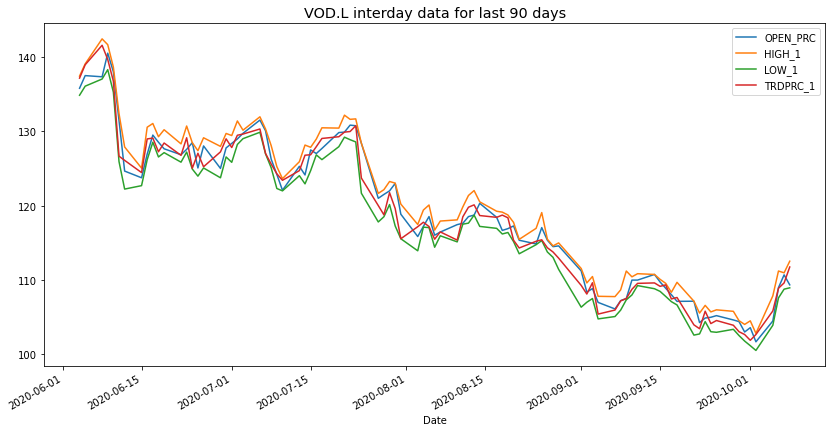

In [18]:
# Plotting a Graph

columns = ['OPEN_PRC','HIGH_1','LOW_1','TRDPRC_1']

df_historical.set_index('Date',drop=True,inplace=True)
fig = plt.figure()
#Format Total Sale display unit as a graph footer.
#fig.text(.5, -.05, 'Open High Low', ha='center',fontsize='large')

# Create graph title from Company and RIC names dynamically.
plt.ticklabel_format(style = 'plain')
plt.title('VOD.L interday data for last 90 days', color='black',fontsize='x-large')
ax = fig.gca()

#df_historical.plot(x="Date", y=columns,figsize=(14,7) )
df_historical.plot(kind='line', ax = fig.gca(),y=columns,figsize=(14,7) )
plt.show()

We will put this grah at the end of report table in Excel sheet. The application can check the position of the last row of report table with xlwings [end()](https://docs.xlwings.org/en/0.20.5/api.html#xlwings.Range.end) function.

In [19]:
historical_last_row = historical_sheet.range('A' + str(historical_sheet.cells.last_cell.row)).end('up').row
historical_last_row

32

Then, get the position of *last row of the table + 3 rows* cell. This makes a space between data table and graph.

In [20]:
rng = historical_sheet.range('B{row}'.format(row = historical_last_row + 3))
rng

<Range [Book1]VOD.L Historical Data!$B$35>

Next, we add this figures as a picture to the xlwings CE sheet obect with [pictures API](https://docs.xlwings.org/en/0.20.5/api.html#pictures).

In [21]:
historical_sheet.pictures.add(fig, name='MyPlot', update=True, top=rng.top, left=rng.left)

<Picture 'MyPlot' in <Sheet [Book1]VOD.L Historical Data>>

The result is the following readable report table:

![Figure-7](images/report_6.png "graph is ready") 

We can create a new excel sheet and export data from RDP to that newly created sheet dynamically.

In [24]:
esg_sheet_title = '%s ESG Data' % (universe)
# Create new sheet for ESG Data
wb.sheets.add(esg_sheet_title)  

<Sheet [Book1]VOD.L ESG Data>

The aboves xlwing statement creates a new sheet in your excel workbook. 

![Figure-8](images/report_7.png "new sheet") 

Then you can get this newly create sheet object and export data to it. I will demonstrate with Environment, Social and Governance data (ESG) using RDP Delivery Layer.

In [25]:
# -- Requesting ESG Data

RDP_version = '/v1'
base_URL = 'https://api.refinitiv.com'

category_URL = '/data/environmental-social-governance'
service_endpoint_URL = '/views/scores-full'

query_parameters = {
    'universe': universe,
    'start': -5,
    'end': 0
}

In [26]:
endpoint_url = base_URL + category_URL + RDP_version + service_endpoint_URL #https://api.refinitiv.com/data/environmental-social-governance/v1/views/scores-full
try:
    endpoint = rdp.Endpoint(session, endpoint_url)
    response = endpoint.send_request( query_parameters = query_parameters )
    print('This is a ESG data result from RDP library')
    print(response.data.raw)
except Exception as exp:
	print('RDP Libraries: Delivery Layer exception: %s' % str(exp))

print('\n')

This is a ESG data result from RDP library
{'links': {'count': 6}, 'variability': 'variable', 'universe': [{'Instrument': 'VOD.L', 'Company Common Name': 'Vodafone Group PLC', 'Organization PermID': '4295896661', 'Reporting Currency': 'EUR'}], 'data': [['VOD.L', '2020-03-31', 44.9021415830974, 81.9095463240896, 7.89473684210526, 71.0261949770456, 81.6403995033954, 90.7932379249935, 81.5217391304347, 68.796992481203, 61.5789473684211, 68.9349112426035, 91.8699186991869, 63.6094674556213, 93.0817610062893, 98.7695749440715, 65.324384787472, 89.1148325358851, 100, 'Grant Thornton UK LLP', '2020-09-18T00:00:00'], ['VOD.L', '2019-03-31', 46.8766590180624, 79.4676037504106, 14.2857142857142, 74.1623221553605, 84.3432263765761, 73.7566542619174, 88.6861313868613, 70.0757575757575, 62.2340425531914, 78.5294117647058, 91.8699186991869, 65, 93.0817610062893, 80.5555555555555, 41.3333333333333, 88.3971291866028, 100, 'Grant Thornton UK LLP', '2020-09-18T00:00:00'], ['VOD.L', '2018-03-31', 66.4344

The return data from RDP Delivery layer is in JSON message format, so you need to convert it to Pandas DataFrame first.

In [31]:
titles = [i["title"] for i in response.data.raw['headers']]
esg_df = pd.DataFrame(response.data.raw['data'],columns=titles)

esg_df.head(2)

,Instrument,Period End Date,ESG Combined Score,ESG Score,ESG Controversies Score,Environment Pillar Score,Social Pillar Score,Governance Pillar Score,Resource Use Score,Emissions Score,...,Workforce Score,Human Rights Score,Community Score,Product Responsibility Score,Management Score,Shareholders Score,CSR Strategy Score,ESG Reporting Scope,ESG Report Auditor Name,ESG Period Last Update Date
0,VOD.L,2020-03-31,44.902142,81.909546,7.894737,71.026195,81.640400,90.793238,81.521739,68.796992,...,68.934911,91.869919,63.609467,93.081761,98.769575,65.324385,89.114833,100,Grant Thornton UK LLP,2020-09-18T00:00:00
1,VOD.L,2019-03-31,46.876659,79.467604,14.285714,74.162322,84.343226,73.756654,88.686131,70.075758,...,78.529412,91.869919,65.000000,93.081761,80.555556,41.333333,88.397129,100,Grant Thornton UK LLP,2020-09-18T00:00:00


In [29]:
esg_sheet = wb.sheets[esg_sheet_title]

#Set Sheet Title
esg_sheet.range("A1").value = 'VOD.L Environmental, Social and Governance Scores for last 5 years'
esg_sheet.range("A1").api.Font.Size = 14 # Change font color
esg_sheet.range("A1").api.Font.ColorIndex = 2 # Change font color
esg_sheet.range('A1:U1').color = (0,0,255) # Change cell background color

The result is following:

![Figure-9](images/report_8.png "set ESG sheet header") 

Then we export DataFrame ```esg_df``` object to ESG sheet ```esg_sheet``` object.

In [30]:
esg_sheet.range("A2").options(index=False).value = esg_df

esg_sheet.range('2:1').api.Font.Bold = True
esg_sheet.range('A2:U2').color = (144,238,144) # Change cell background color

![Figure-10](images/report_9.png "set ESG report data") 

Then we save this excel file with xlwings ```Book``` object ```save()``` function.

In [32]:
wb.save('rdp_report.xlsx')

## Reporting with xlwings PRO

The above example source code shows that you can create an excel report file of Refinitiv Data with xlwings CE API pretty easy.

However, the Python source code is mixuped between formatting report look & feel and handle data which make the source code hard to maintain and hard to read in the long run.

The [xlwings PRO ](https://www.xlwings.org/pro) has features to solve all of CE version limitations. The [xlwings PRO report package](https://www.xlwings.org/reporting) provides a capability to generate excel report file with the following features:
- **Separation of code and design**: Users without coding skills can change the template on their own without having to touch the Python code.
- **Template variables**: Python variables (between curly braces) can be directly used in cells , e.g. ```{{ title }}```. They act as placeholders that will be replaced by the actual values.
- **Frames for dynamic tables**: Frames are vertical containers that dynamically align and style tables that have a variable number of rows.

You can get a free trial for xlwings PRO [here](https://www.xlwings.org/pro). 

Now let import the report package from xlwings PRO.


In [34]:
from xlwings.pro.reports import create_report

In [49]:
# Resize figure
# fig.set_size_inches(6.4, 4.8)

Next, let create an excel template file name *rdp_report_template.xlsx*. 

![Figure-11](images/report_pro_template_1.png "pro report template") 

This tempalte defines all look and feel (font, color, etc) and also position of auto generated data with varaible inside ```{{``` and ```}}```.

Then use the [report-api](https://docs.xlwings.org/en/stable/api.html#reports-api) to generate excel file based on a template file and data with ```create_report()``` function.

In [ ]:
wb = create_report(
    'rdp_report_template.xlsx', 
    'rdp_report_pro.xlsx', 
    historical_title=historical_title, 
    df_historical=df_historical.head(10), 
    graph= fig
)

![Figure-12](images/report_pro_2.png "pro report result") 

The application does need to interact or hardcode setting cell, sheet and workbook anymore. The xlwings PRO report package automatic replace ```{{ historical_title }}```, ```{{ df_historical }}``` and ```{{graph}}``` variables wtih data that the application pass through report package's ```create_report()``` function.

The application can pass text, DataFrame or even Graph to the function and xlwings will generate the excel report file based on the look and feel of template file.

### Close RDP Session

In [ ]:
# -- Close Session, just calls close_session() function

rdp.close_session()

print(session.get_open_state())

## Conclution and Next Step

The xlwings CE lets Python developers intergate data with Excel in a simple way. The library is suitable for a wide range of developers from casual coder, data scientists, professional trader to seasoned programmer to work on data analysis and generate report based on their skill. 

The next part will cover and show how powerful xlwings PRO is when comparing to CE library. Python developers life will be more easier with xlwings PRO.

In the same time, the [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/refinitiv-data-platform/refinitiv-data-platform-libraries) let developers rapid access Refinitiv Platform content with a few line of code that easy to understand and maintenance. Developers can focus on implement the business logic or analysis data without worry about the connection, authentication detail with the Refinitiv Platforms.

The integration between Refinitiv APIs and xlwings is not limited to only RDP Libraries. Any [Refintiv APIs](https://developers.refinitiv.com/en/api-catalog?i=1;q1=page-type%3Aapi;q2=devportal%3Alanguages~2Fpython;sort=title;sp_c=12;sp_cs=UTF-8;sp_k=devportal-prod;view=xml;x1=w-page-type-id;x2=api-language) that support Python such as [Eikon Data API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api) ([Eikon Data API-xlwings article](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel)), [RKD API](https://developers.refinitiv.com/en/api-catalog/refinitiv-knowledge-direct/refinitiv-knowledge-direct-api-rkd-api) can work with xlwings in the same concept and code logic. 


## References

You can find more detail regarding the Refinitiv Data Platform Libraries, Xlwings and related technologies for this notebook from the following resources:
* [Refinitiv Data Platform (RDP) Libraries](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) web site.
* [Xlwings web site](https://www.xlwings.org/).
* [RDP Libraries Quick Start Guide page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/quick-start).
* [RDP Libraries Tutorial page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-libraries/tutorials).
* [Xlwings Document page](https://docs.xlwings.org/en/stable/).
* [Discover our Refinitiv Data Platform Library (part 1)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-1).
* [Discover our Refinitiv Data Platform Library (part 2)](https://developers.refinitiv.com/en/article-catalog/article/discover-our-refinitiv-data-platform-library-part-2).
* [Financial Reporting with Eikon and Excel](https://developers.refinitiv.com/en/article-catalog/article/financial-reporting-with-eikon-and-excel).
* [Xlwings API Reference](https://docs.xlwings.org/en/stable/api.html).

For any question related to this article or Refinitiv Data Platform Libraries, please use the Developers Community [Q&A Forum](https://community.developers.refinitiv.com/spaces/321/refinitiv-data-platform-libraries.html).